In [1]:
#pip install regressors

In [2]:
import pandas_datareader as wb
from pandas_datareader import data
import yfinance as yf
import requests 
import pandas as pd
import numpy as np
import math
from lxml import html
import datetime
from datetime import datetime
import statsmodels.api as sm
from scipy.stats import norm
from tqdm.notebook import tqdm

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression 
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, r2_score
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

In [5]:
#function for calculating log return
def return_df(close_price_df):
        
    return_df = close_price_df.pct_change().apply(lambda x: np.log(1+x))
    
    return return_df

#function for classifing beaters and losers
def dummies_beater(all_returns,Rf, option = "return"):
    
    all_returns = all_returns.dropna(how="all")
    Rm = all_returns["SPY"]
    Rm = Rm.fillna(0)
    comps_R = all_returns.drop(columns = ["SPY"])
    comps_R = comps_R.fillna(0)
    
    if option == "return":
        comps_R_excess = comps_R.subtract(Rm.values, axis=0)
        dummies_Return_beaters = comps_R_excess.copy()
        dummies_Return_beaters[dummies_Return_beaters >= 0] =1
        dummies_Return_beaters[dummies_Return_beaters < 0] =0
        
    elif option == "sharpe":
        market_volatility = Rm.std()
        comps_volatility = comps_R.std()
        comps_sharpe = (comps_R - Rf)/comps_volatility
        market_sharpe = (Rm - Rf)/market_volatility
        sharpe_excess = comps_sharpe.subtract(market_sharpe, axis=0)
        dummies_Return_beaters = sharpe_excess.copy()
        dummies_Return_beaters[dummies_Return_beaters >= 0] =1
        dummies_Return_beaters[dummies_Return_beaters < 0] =0
        
    return dummies_Return_beaters

In [26]:
def FF_assign_label(index_comp_info):    
#Assign Label indicating the companies' charactaristics, Big cap, High value...

    #Companies have market cap above median are classified as big cap, otherwise small cap    
    index_comp_info["bookToMarket"] = 1/index_comp_info["PB_ratio"]
    index_comp_info["Small_Big_Cap"] = index_comp_info["mkt_cap"].map(lambda x: "B" if x >= index_comp_info["mkt_cap"].median() else "S")
    
    #Companies have BP ratio above 0.75 percentile are classified as high value(High), under 0.25 percentile as low value(Low)
    lower, upper = index_comp_info["bookToMarket"].quantile([0.3, 0.7])
    index_comp_info["HML_BP"] = index_comp_info["bookToMarket"].map(lambda x: "H" if x >= upper else "M")
    index_comp_info["HML_BP"] = index_comp_info.apply(lambda row: "L" if row["bookToMarket"] <= lower else row["HML_BP"], axis = 1)
    
    #Companies have ROE above 0.75 percentile are classified as high profit(Robust), under 0.25 percentile as low profit(Weak)
    lower_roe, upper_roe = index_comp_info["ROE"].quantile([0.3, 0.7])
    index_comp_info["RNW_ROE"] = index_comp_info["ROE"].map(lambda x: "R" if x >= upper_roe else "N")
    index_comp_info["RNW_ROE"] = index_comp_info.apply(lambda row: "W" if row["ROE"] <= lower_roe else row["RNW_ROE"], axis = 1)
    
    #Companies have asset growth above 0.75 percentile are classified as high investment(Aggresive), under 0.25 percentile as low investment(Conservative)
    lower_invest, upper_invest = index_comp_info["Asset_growth"].quantile([0.3, 0.7])
    index_comp_info["ANC_investment"] = index_comp_info["Asset_growth"].map(lambda x: "A" if x >= upper_invest else "N")
    index_comp_info["ANC_investment"] = index_comp_info.apply(lambda row: "C" if row["Asset_growth"] <= lower_invest else row["ANC_investment"], axis = 1)
            
    return index_comp_info

def FF_factor_classifier(index_comp_info_with_label):
#Classifing companies to 18 groups for later return calculation

    data = index_comp_info_with_label
    
    #grouping data
    Small_Low = data.query('(Small_Big_Cap=="S") & (HML_BP=="L")')
    Small_Mid = data.query('(Small_Big_Cap=="S") & (HML_BP=="M")')
    Small_High = data.query('(Small_Big_Cap=="S") & (HML_BP=="H")')
    
    Small_Weak = data.query('(Small_Big_Cap=="S") & (RNW_ROE=="W")')
    Small_Neutral_Profit = data.query('(Small_Big_Cap=="S") & (RNW_ROE=="N")')
    Small_Robust = data.query('(Small_Big_Cap=="S") & (RNW_ROE=="R")')
    
    Small_Conservative =  data.query('(Small_Big_Cap=="S") & (ANC_investment=="C")')
    Small_Neutral_Invest =  data.query('(Small_Big_Cap=="S") & (ANC_investment=="N")')
    Small_Aggresive =  data.query('(Small_Big_Cap=="S") & (ANC_investment=="A")')
    
    Big_Low = data.query('(Small_Big_Cap=="B") & (HML_BP=="L")')
    Big_Mid = data.query('(Small_Big_Cap=="B") & (HML_BP=="M")')
    Big_High = data.query('(Small_Big_Cap=="B") & (HML_BP=="H")')
    
    Big_Weak = data.query('(Small_Big_Cap=="B") & (RNW_ROE=="W")')
    Big_Neutral_Profit = data.query('(Small_Big_Cap=="B") & (RNW_ROE=="N")')
    Big_Robust = data.query('(Small_Big_Cap=="B") & (RNW_ROE=="R")')

    Big_Conservative =  data.query('(Small_Big_Cap=="B") & (ANC_investment=="C")')
    Big_Neutral_Invest = data.query('(Small_Big_Cap=="B") & (ANC_investment=="N")')
    Big_Aggresive =  data.query('(Small_Big_Cap=="B") & (ANC_investment=="A")')
    
    #store grouped data to a list
    each_groups_list = [Small_Low, Small_Mid, Small_High, 
                            Small_Weak, Small_Neutral_Profit, Small_Robust,
                            Small_Conservative, Small_Neutral_Invest, Small_Aggresive,
                            Big_Low, Big_Mid,Big_High,
                            Big_Weak, Big_Neutral_Profit, Big_Robust,
                            Big_Conservative, Big_Neutral_Invest, Big_Aggresive]
        
    return each_groups_list

def FF_classes_return(market_components_return, list_of_group_info, axis=True):
# Calculate value-weighted return of each group above       
    
    groups_names = ["Small_Low", "Small_Mid", "Small_High",
                        "Small_Weak", "Small_Neutral_Profit", "Small_Robust",
                        "Small_Cons", "Small_Neutral_Invest", "Small_Aggr",
                        "Big_Low", "Big_Mid","Big_High",
                        "Big_Weak", "Big_Neutral_Profit", "Big_Robust",
                        "Big_Cons", "Big_Neutral_Invest", "Big_Aggr"]
    
    df_groups = pd.DataFrame(columns = groups_names)
    
    counter = 0
    
    for group in list_of_group_info:
        
        #calculating value-weighted return for each group above
        group_cap = group["mkt_cap"].T
        group_total_cap = group["mkt_cap"].sum()
        group_cap_multi_return = group_cap*market_components_return[list(group.index)]
        
        if axis == True:
            df_groups[groups_names[counter]] = group_cap_multi_return.apply(lambda row: row.sum()/group_total_cap, axis=1)
        
        else:
            groups_index_return = group_cap_multi_return.sum()/group_total_cap
            df_groups[groups_names[counter]] = [groups_index_return]
    
        counter += 1
                
    return df_groups

def FF_calc_factors(classes_return_df, df = True):
#Calculate 5 factors (5 Return Spreads)

    factor_name = ["SMB", "HML", "RMW", "CMA"]
    
    SMB_BP = (classes_return_df["Small_Low"] + classes_return_df["Small_Mid"] 
                      + classes_return_df["Small_High"]) - (classes_return_df["Big_Low"]
                      + classes_return_df["Big_Mid"] + classes_return_df["Big_High"])/3
    
    SMB_PFT = (classes_return_df["Small_Weak"] + classes_return_df["Small_Neutral_Profit"] 
                      + classes_return_df["Small_Robust"]) - (classes_return_df["Big_Weak"]
                      + classes_return_df["Big_Neutral_Profit"] + classes_return_df["Big_Robust"])/3
    
    SMB_INV = (classes_return_df["Small_Cons"] + classes_return_df["Small_Neutral_Invest"] 
                      + classes_return_df["Small_Aggr"]) - (classes_return_df["Big_Cons"]
                      + classes_return_df["Big_Neutral_Invest"] + classes_return_df["Big_Aggr"])/3
    
    if df == True:
        
        FF_factors_data = pd.DataFrame(columns = factor_name)
        
    #Pure algebra
    
    FF_factors_data["SMB"] = (SMB_BP + SMB_PFT + SMB_INV)/3
    
    FF_factors_data["HML"] = (classes_return_df["Small_High"] + classes_return_df["Big_High"]
                      - (classes_return_df["Small_Low"] + classes_return_df["Big_Low"])) / 2
    
    FF_factors_data["RMW"] = (classes_return_df["Small_Robust"] + classes_return_df["Big_Robust"]
                      - (classes_return_df["Small_Weak"] + classes_return_df["Big_Weak"])) / 2
    
    FF_factors_data["CMA"] = (classes_return_df["Small_Cons"] + classes_return_df["Big_Cons"]
                      - (classes_return_df["Small_Aggr"] + classes_return_df["Big_Aggr"])) / 2
        
    return FF_factors_data

def FF_regress(FF_factors_df, target_comp_risk_premium, modelType = 'linear', transform = False):
#Function to estimate factor exposure for given stock return series

    #dependent variable is a given return premium(R-Rf) series
    y = target_comp_risk_premium
    
    #Transform the features to interaction polynomial form 
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    poly_X = poly.fit_transform(FF_factors_df)
    poly_FF = pd.DataFrame(data = poly_X, index=FF_factors_df.index)
    
    #If chose lasso, always use polynomial features. We have only 5 features in normal form, likely to underfit if use lasso.
    if modelType == 'lasso':
        
        X = poly_FF
        
        model = linear_model.Lasso(alpha = 0.00000001)
        model.fit(X.astype(float), y.astype(float))
        params = np.append(model.intercept_,model.coef_)
        predictions = model.predict(X)
        
    #Linear model has both options  
    elif modelType == 'linear':
        
        if transform == True:
            X = poly_FF
        
        elif transform == False:
            X = FF_factors_df
            
        model = linear_model.LinearRegression()
        model.fit(X.astype(float), y.astype(float))
        params = np.append(model.intercept_,model.coef_)
        predictions = model.predict(X)
        
    #Ridge model with cross validation has both options    
    elif modelType == 'ridge':
    
        if transform == True:
            X = poly_FF
            set_alphas=[0.000001,0.0000001]
            
        elif transform == False:
            X = FF_factors_df
            set_alphas = [0.00000001,0.0000001]
            
        model = linear_model.RidgeCV(alphas = set_alphas, cv=5)
        model.fit(X.astype(float), y.astype(float))
        params = np.append(model.intercept_,model.coef_)
        predictions = model.predict(X)
        
    #Elastic Net model with cross validation has both options    
    elif modelType == 'elastic':
        
        if transform == True:
            X = poly_FF
            set_alphas = [0.000001,0.0000001]
        
        elif transform == False:
            X = FF_factors_df
            set_alphas = [0.00000001,0.0000001]
            
        model = linear_model.ElasticNetCV(alphas = set_alphas, cv=5, random_state=0)
        model.fit(X.astype(float), y.astype(float))
        params = np.append(model.intercept_,model.coef_)
        predictions = model.predict(X)
    
    #calculating MSE, coefficoent, p-value, and R^2
    newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X.reset_index(drop=True)))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b
    
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(X.columns)))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard_Errors"],myDF3["t_stat"],myDF3["P_value"] = [params,sd_b,ts_b,p_values]
    R2 = r2_score(y,predictions)
    
    #returning a dataframe contains coefficients, significance level, and % of variation explained
    return myDF3 , R2

def regressAll(FF_factors, all_returns, days, train_base, Rf=0.000001, modelType = 'linear', transform=False):
#functions to regress all inputing comapnies and store R^2, BETAS, P-VAL using above function, AND the target variable (outcome at T+1)    
    
    #Converting return df to dummy variable df indicating wheather a comapny is a beater at given time
    dummies_Return_beaters = dummies_beater(all_returns, Rf)
    
    #calculating the probability of beating the market from last 10,20, and 30 observations
    prob_10obs = dummies_Return_beaters.iloc[days - 10 : days].mean().T
    prob_20obs = dummies_Return_beaters.iloc[days - 20 : days].mean().T
    prob_30obs = dummies_Return_beaters.iloc[days - 30 : days].mean().T
    
    #set the target variables as the T+1 status(winner or loser)
    target = dummies_Return_beaters.iloc[days+1]
    
    #Lasso always has transformed features
    if modelType == "lasso":
        transform = True
    
    #optional poly features for the rest of models
    if transform == True:
        features_df = pd.DataFrame(columns = ["const",'B1', 'B2', 'B3', 'B4', 'B5'
                                              ,'B6', 'B7', 'B8', 'B9', 'B10',"B11"
                                              ,"B12","B13","B14","B15"
                                              ,"Pval_C", "Pval1", "Pval2", "Pval3", "Pval4", "Pval5"
                                              ,"Pval6", "Pval7", "Pval8", "Pval9", "Pval10", "Pval11"
                                              ,"Pval12","Pval13", "Pval14","Pval15"
                                              , 'R2'],
                               index = all_returns.columns)
        
    else:    
        features_df = pd.DataFrame(columns = ["const",'B1', 'B2', 'B3', 'B4', 'B5',"Pval_C", "Pval1", "Pval2", "Pval3", "Pval4", "Pval5", 'R2'],
                               index = all_returns.columns)
    
    #Dropping the SPY from dataframe because that is market performence, and we are not interested in its exposures
    comps_R = all_returns.drop(columns = ["SPY"]).fillna(0)
    
    #Fill NaN for FF factors because it indicated 2 min return spread is too small to capture
    FF_factors = FF_factors.fillna(0)
    
    #Looping over all companies in SP500 index to measure their coefficients and othe features that will be used for prediction
    for i in comps_R:

        regression_stat, R2 = FF_regress(FF_factors.iloc[days-train_base:days], comps_R[i].iloc[days-train_base:days], modelType, transform)
        betas = list(regression_stat["Coefficients"])
        Pvals = list(regression_stat["P_value"])
        features = betas + Pvals
        features.append(R2)
        features_df.loc[i] = features
    
    #Construct a complete dataframe containing target variable
    features_df["prob_10obs"], features_df["prob_20obs"], features_df["prob_30obs"] = [prob_10obs, prob_20obs, prob_30obs]
    features_df["true_target"] = target

    return features_df
    
def performence_df(FF_2m_factor,total_2m_return, Rf, modelType = "linear", transform = False):
#Fuction to collect performence data from pre-set testing trials

    performence = pd.DataFrame(columns=["precision", "recall", "f1"])
    
    #we use past 150 observation to estimate factor exposure
    days = 150
    
    #Using while loop to control the number of testing trials. Setting the testing trial to 2 (the difference between train base and final "days") for testing the code is working 
    while days < 152:
        
        data = regressAll(FF_2m_factor,total_2m_return,days,train_base = 150, Rf = Rf, modelType = modelType, transform = transform)
        data = data.fillna(0)
        
        #Split the training set and testing set
        split = int(len(data)*0.6)
        
        #No need to randomize index because the data is sorted by the first letter of the company, so the indexing doesn't cause bias
        training_set = data.iloc[:split]
        testing_set = data.iloc[split:]
        
        Xtrain, ytrain = training_set.drop(columns=["true_target"]), training_set["true_target"] #seperate from target
        Xtest = testing_set.drop(columns=["true_target"]) #Isolate the True Outcome
        
        #constructing 4 classifiers
        sgd_clf = SGDClassifier(random_state = 42,loss = 'modified_huber')
        model1 = sgd_clf.fit(training_set.drop(columns=["true_target"]),training_set["true_target"])
        log_clf = LogisticRegression(solver="lbfgs", random_state=42)
        rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
        svm_clf = SVC(gamma="scale", random_state=42, probability=True)
        
        #Fitting 4 models on training set
        model1 = sgd_clf.fit(Xtrain, ytrain)
        model2 = log_clf.fit(Xtrain, ytrain)
        model3 = rnd_clf.fit(Xtrain, ytrain)
        model4 = svm_clf.fit(Xtrain, ytrain)
        
        #Implemeting Bagging to reduce bias for all 4 classifiers
        bag_clf1 = BaggingClassifier(SGDClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
        model5 = bag_clf1.fit(training_set.drop(columns=["true_target"]),training_set["true_target"])
        y_pred1 = bag_clf1.predict(testing_set.drop(columns=["true_target"]))
        
        bag_clf2 = BaggingClassifier(LogisticRegression(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
        model6 = bag_clf2.fit(training_set.drop(columns=["true_target"]),training_set["true_target"])
        y_pred2 = bag_clf1.predict(testing_set.drop(columns=["true_target"]))
        
        bag_clf3 = BaggingClassifier(RandomForestClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
        model7 = bag_clf3.fit(training_set.drop(columns=["true_target"]),training_set["true_target"])
        y_pred3 = bag_clf3.predict(testing_set.drop(columns=["true_target"]))
        
        bag_clf4 = BaggingClassifier(SVC(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
        model8 = bag_clf4.fit(training_set.drop(columns=["true_target"]),training_set["true_target"])
        y_pred4 = bag_clf4.predict(testing_set.drop(columns=["true_target"]))
        
        #Vote one time for classifiers w/o bagging
        voting_clf1 = VotingClassifier(
        estimators=[('sgd',sgd_clf),('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
        voting='soft')
        final_model1 = voting_clf1.fit(Xtrain, ytrain)
        
        #Vote second time for classifiers w/ bagging
        voting_clf2 = VotingClassifier(
        estimators=[('bag1', model5),('bag2', model6), ('bag3', model7), ('bag4', model8)],
        voting='soft')
        final_model2 = voting_clf2.fit(Xtrain, ytrain)
        
        #Final vote for selecting classifiers
        voting_clf_final = VotingClassifier(
        estimators=[('first', final_model1),('second', final_model1)],
        voting='soft')
        real_final_model = voting_clf_final.fit(Xtrain, ytrain)
        
        #making prediction based on features
        prediction = real_final_model.predict(Xtest)
        testing_set = testing_set.copy()
        
        #combining prediction with testing set
        testing_set["prediction"] = prediction
        
        #defining true value and predicted value to calculate accuracy score later
        true_target_value = testing_set["true_target"]
        predicted_value = testing_set["prediction"]
        
        #caculate three score, but we most care about precision
        precision = precision_score(true_target_value, predicted_value)
        recall = recall_score(true_target_value, predicted_value)
        f1 = f1_score(true_target_value, predicted_value)
        
        #creating performence dataframe
        score_series = pd.Series([precision, recall, f1], index = performence.columns)
        performence = performence.append(score_series, ignore_index=True)
    
        days += 1
    
    return performence

    

# Loading Data

This involves pre-loading the datasets provided in the github. First dataset loaded is the Fama-Factor observatios for each company.

In [7]:
FF_info = pd.read_csv("Fama_French_info.csv", index_col = 0)

This dataset is is the 2 minute close price data which will be used to find return information.

In [8]:
sp_2m_close = pd.read_csv("SPYn500_2m_close.csv", index_col = 0)

Verify data has loaded correctly.

In [9]:
sp_2m_close.iloc[:3]

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-10-11 09:30:00-04:00,150.729996,20.120001,214.000000,141.949997,111.199997,120.519997,333.580200,118.260002,324.829987,571.551025,...,61.740002,154.020004,62.622299,58.139999,121.169998,123.730003,146.309998,492.0,64.209999,196.289993
2021-10-11 09:32:00-04:00,150.690002,20.020000,213.889999,142.850006,111.160004,121.260002,333.104889,118.154999,325.119995,574.900024,...,62.064999,155.339996,62.560001,58.119999,121.239998,123.787201,146.315002,NaN,63.900002,196.509995
2021-10-11 09:34:00-04:00,151.330002,19.870001,214.000000,142.889999,111.129997,121.184998,335.989990,118.599998,324.910004,575.900024,...,62.360001,155.895004,62.556599,58.000000,120.980003,123.180000,NaN,NaN,63.650002,196.820007


# Calculate log-return (Return is log-normal)

Call return function to calculate percent return for each time interval.

In [10]:
total_2m_return = return_df(sp_2m_close)

Remove null rows.

In [11]:
#First row is always NaN
total_2m_return = total_2m_return.dropna(how = "all")

In [12]:
#Fill NaN with 0 in return df because NaN value represent a number too close to 0
total_2m_return = total_2m_return.fillna(0)

Verify null values have been removed.

In [13]:
total_2m_return.iloc[:3]

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-10-11 09:32:00-04:00,-0.000265,-0.004983,-0.000514,0.006320,-0.000360,0.006121,-0.001426,-0.000888,0.000892,0.005842,...,0.005250,0.008534,-0.000995,-0.000344,0.000578,0.000462,0.000034,0.000000,-0.00484,0.001120
2021-10-11 09:34:00-04:00,0.004238,-0.007521,0.000514,0.000280,-0.000270,-0.000619,0.008624,0.003759,-0.000646,0.001738,...,0.004742,0.003566,-0.000054,-0.002067,-0.002147,-0.004917,0.000000,0.000000,-0.00392,0.001576
2021-10-11 09:36:00-04:00,-0.004039,0.002789,-0.000187,-0.001891,0.000315,0.003336,0.000000,-0.003886,0.000062,-0.001808,...,-0.000802,0.000673,0.003406,-0.001035,0.001280,0.000244,0.001264,0.002923,0.00157,-0.000762


# Defining components return, market return, dummies beater

Seperate market ETF from other companies to make comparisons later.

In [15]:
sp500_2m_return = total_2m_return.drop(columns=["SPY"])

This is used to find market benchmark which is Rm_2m - Rf.

In [16]:
Rm_2m = total_2m_return[['SPY']]
#need to discount Monthly Rf to 2m Rf using yield curve(continuously compounded) when doing real time analysis
#Rf is always a constant, so we set a small value for research purpose
Rf = 0.000001

Calls the dummy beater function to label our data for our supervised classification model. This dataset will return binary values indicating if a certain stock beat the market at a certain time based on the sharpe ratio.

In [17]:
dummies_2m_beater = dummies_beater(total_2m_return, Rf, option="sharpe")

Verify dataset has loaded correctly.

In [18]:
dummies_2m_beater.iloc[:3]

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-10-11 09:32:00-04:00,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-11 09:34:00-04:00,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
2021-10-11 09:36:00-04:00,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0


# Feature Engineering

## Calculate FF factors

This calls our various Fama-French functions in order to calculate the factors which were significant at a certain time.

In [19]:
#Calculate 2min FF factors (5 return spreads)
FF_info_labeled = FF_assign_label(FF_info)
FF_classified_list = FF_factor_classifier(FF_info_labeled)
FF_2m_classes_return = FF_classes_return(sp500_2m_return,FF_classified_list)
FF_2m_factor = FF_calc_factors(FF_2m_classes_return)
FF_2m_factor["Rm-Rf"] = Rm_2m - Rf

Account for null values.

In [20]:
# fill NaN with 0 for FF factors because the value is too small
FF_2m_factor = FF_2m_factor.fillna(0)

Verify the dataset has loaded correctly.

In [21]:
FF_2m_factor.iloc[:3]

,SMB,HML,RMW,CMA,Rm-Rf
Datetime,,,,,
2021-10-11 09:32:00-04:00,-0.001462,-0.003179,0.001835,-0.000872,0.001503
2021-10-11 09:34:00-04:00,-0.005193,-0.002111,0.001227,-0.000469,-0.001025
2021-10-11 09:36:00-04:00,0.004055,0.001614,-0.001921,0.001213,0.000136


## Calculate features and relevant statistic for given company 

Because of multi-collinearity between FF factors, we need to incorporate models like ridge regression and elastic net into parameters estimation process. The default argument is linear model without polynomial features. 

In [22]:
FF_regress(FF_2m_factor, sp500_2m_return["AAPL"]-Rf)

(   Coefficients  Standard_Errors  t_stat  P_value
 0        0.0000            0.000   0.325    0.745
 1       -0.3181            0.012 -27.625    0.000
 2       -0.4702            0.022 -21.836    0.000
 3        0.6130            0.024  25.983    0.000
 4        1.4745            0.030  49.395    0.000
 5        1.6016            0.027  59.135    0.000,
 0.5610279415110841)

Other regression models can be used by specifing an input variable; modelType is for model selection and transform is for polynomial feature transformation.

In [23]:
FF_regress(FF_2m_factor, sp500_2m_return["AAPL"]-Rf, modelType="ridge", transform = True)

(    Coefficients  Standard_Errors  t_stat  P_value
 0         0.0000            0.000   0.391    0.696
 1        -0.3057            0.012 -25.817    0.000
 2        -0.4700            0.023 -20.178    0.000
 3         0.5877            0.027  21.563    0.000
 4         1.3688            0.034  40.837    0.000
 5         1.6059            0.027  58.914    0.000
 6        10.0791           10.604   0.950    0.342
 7         0.7609           13.778   0.055    0.956
 8        11.1005           16.400   0.677    0.499
 9        -8.8915            4.051  -2.195    0.028
 10        0.9623           20.723   0.046    0.963
 11       -5.5943           11.254  -0.497    0.619
 12        6.8146           26.527   0.257    0.797
 13        1.1029           16.183   0.068    0.946
 14       -1.0358           44.089  -0.023    0.981
 15        6.0549           40.793   0.148    0.882,
 0.594822401538648)

# Time Series model construction

The long term probability for any company to beat the market is 0.5, but we suspect serial correlation exists, so we measure the probability of beating the market for last 10, 20, and 30 observations and add them as features for time-series prediction.

  0%|          | 0/1000 [00:00<?, ?it/s]

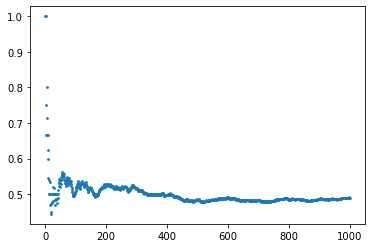

In [24]:
time_length = range(len(dummies_2m_beater.index[:1000]))
winner_rate_list = []
for length in tqdm(time_length):
    winner_rate = dummies_2m_beater["AAPL"].iloc[:length].mean()
    winner_rate_list.append(winner_rate)
    
plt.scatter(time_length, winner_rate_list, s=3)

Our goal is to predict wheather a given security or portfolio will outperform the market in the next trading period, so we estimate factor exposure based on a given amount of most recent observations at T0 and use the exposures+relevant statistic to predict the outcome at T1. Since the probability of beating the market will converge to 0.5 as observation increase, we also include realized probabilities that are observe from last 10, 20, and 30 observations as features. We will roll the model and make prediction for at least 10 trading period, and will collect accuracy metrics of time-series prediction.

# Test the model performence over time

The first prediction uses the default arguements which uses linear regression without polynomial features.

In [28]:
p1 = performence_df(FF_2m_factor,total_2m_return, Rf=Rf)

In [29]:
p1

,precision,recall,f1
0,0.772727,0.283333,0.414634
1,0.500000,0.717391,0.589286


Second prediction uses lasso sci-kit linear regression model.

In [30]:
p2 = performence_df(FF_2m_factor,total_2m_return, Rf=Rf, modelType="lasso")

In [31]:
p2

,precision,recall,f1
0,0.755556,0.566667,0.647619
1,0.473333,0.771739,0.586777


Third prediction uses elastic model without polynomial features.

In [32]:
p3 = performence_df(FF_2m_factor,total_2m_return, Rf=Rf, modelType="elastic", transform=False)

In [33]:
p3

,precision,recall,f1
0,0.700000,0.525000,0.600000
1,0.475904,0.858696,0.612403


Fourth prediction uses ridge model without polynomial features.

In [34]:
p4 = performence_df(FF_2m_factor,total_2m_return, Rf=Rf, modelType="ridge")

In [35]:
p4

,precision,recall,f1
0,0.764706,0.216667,0.337662
1,0.610390,0.510870,0.556213


Fourth prediction uses ridge model with polynomial features.

In [36]:
p5 =  performence_df(FF_2m_factor,total_2m_return, Rf=Rf, modelType="ridge", transform=True)

In [37]:
p5

,precision,recall,f1
0,0.882353,0.250000,0.389610
1,0.484472,0.847826,0.616601


Fifth prediction uses elastic model with polynomial features.

In [38]:
p6 = performence_df(FF_2m_factor,total_2m_return, Rf=Rf, modelType="elastic" , transform=True)

In [39]:
p6

,precision,recall,f1
0,0.804878,0.275000,0.409938
1,0.464088,0.913043,0.615385


It is interesting to observe that our algorithm predicts not-buy signals better than buy signals. This isn't too concerning in finance as the opposite issue is much worse. In this case we prefer false-negatives instead of false-positives.

# Result from testing the models 100 trading period

We now load the dataset of rolling the model over a much larger timeframe to visualize our results.

In [40]:
result = pd.read_csv("performence_2m_100obs.csv")

In [41]:
linear_wo_poly_result = result[result["model"]=="linear_wo_poly_100p"]
lasso_wo_poly_result = result[result["model"]=="lass_wo_poly_100p"]
elastic_wo_poly_result = result[result["model"]=="ela_wo_poly_100p"]
ridge_wo_poly_result = result[result["model"]=="ridg_wo_poly_100p"]
ridge_w_poly_result = result[result["model"]=="ridg_w_poly_100p"]
elastic_w_poly_result = result[result["model"]=="ela_w_poly_100p"]

## Summary Statistics

Below we visualize results and get summary statistics for our report.

In [42]:
linear_wo_poly_result.describe().drop(columns = ["test_trial"])

,precision,recall,f1
count,100.000000,100.000000,100.000000
mean,0.626702,0.617759,0.591196
std,0.125047,0.255708,0.190314
min,0.125000,0.014085,0.025316
25%,0.567441,0.454545,0.519211
50%,0.643719,0.685658,0.631049
75%,0.706163,0.811128,0.727281
max,1.000000,0.977099,0.855263


In [43]:
lasso_wo_poly_result.describe().drop(columns = ["test_trial"])

,precision,recall,f1
count,100.000000,100.000000,100.000000
mean,0.640537,0.603010,0.570042
std,0.129128,0.304059,0.209609
min,0.333333,0.012048,0.023810
25%,0.563189,0.342210,0.472376
50%,0.647059,0.647451,0.626786
75%,0.731012,0.891730,0.726955
max,1.000000,1.000000,0.855385


In [44]:
elastic_wo_poly_result.describe().drop(columns = ["test_trial"])

,precision,recall,f1
count,100.000000,100.000000,100.000000
mean,0.614607,0.620836,0.583194
std,0.127430,0.277294,0.194003
min,0.000000,0.000000,0.000000
25%,0.563590,0.381225,0.467645
50%,0.631579,0.687131,0.627845
75%,0.706196,0.862698,0.719450
max,0.818182,0.990654,0.849231


In [45]:
ridge_wo_poly_result.describe().drop(columns = ["test_trial"])

,precision,recall,f1
count,100.000000,100.000000,100.000000
mean,0.627760,0.628140,0.593217
std,0.114258,0.267591,0.190194
min,0.333333,0.014085,0.027027
25%,0.571894,0.416064,0.493601
50%,0.641893,0.691882,0.624603
75%,0.709202,0.863731,0.756564
max,0.833333,0.991870,0.860000


In [46]:
ridge_w_poly_result.describe().drop(columns = ["test_trial"])

,precision,recall,f1
count,100.000000,100.000000,100.000000
mean,0.615665,0.664768,0.597795
std,0.140617,0.288974,0.189151
min,0.000000,0.000000,0.000000
25%,0.535866,0.430242,0.521350
50%,0.618615,0.756650,0.630741
75%,0.704893,0.916274,0.741657
max,1.000000,1.000000,0.852564


In [47]:
elastic_w_poly_result.describe().drop(columns = ["test_trial"])

,precision,recall,f1
count,100.000000,100.000000,100.000000
mean,0.645330,0.610424,0.558490
std,0.138658,0.330413,0.220915
min,0.000000,0.000000,0.000000
25%,0.562158,0.293416,0.420156
50%,0.663176,0.708401,0.631054
75%,0.750619,0.916691,0.733838
max,1.000000,1.000000,0.858974


# Result Visualizations

### Precision distributions are mostly normal, and precision score doesn't show evidence of serial correlation.

C:\Users\steve\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Scatter'}, xlabel='test_trial', ylabel='precision'>

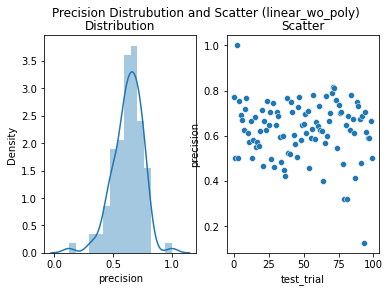

In [60]:
fig, axes = plt.subplots(1, 2)
fig.suptitle("Precision Distrubution and Scatter (linear_wo_poly)")
axes[0].set_title("Distribution")
axes[1].set_title("Scatter")
sns.distplot(linear_wo_poly_result["precision"], ax = axes[0])
sns.scatterplot(x = "test_trial", y = "precision", data=linear_wo_poly_result, ax = axes[1])

C:\Users\steve\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Scatter'}, xlabel='test_trial', ylabel='precision'>

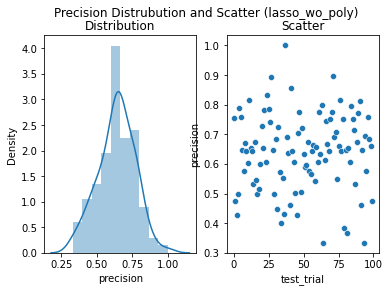

In [61]:
fig, axes = plt.subplots(1, 2)
fig.suptitle("Precision Distrubution and Scatter (lasso_wo_poly)")
axes[0].set_title("Distribution")
axes[1].set_title("Scatter")
sns.distplot(lasso_wo_poly_result["precision"], ax = axes[0])
sns.scatterplot(x = "test_trial", y = "precision", data=lasso_wo_poly_result, ax = axes[1])

C:\Users\steve\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Scatter'}, xlabel='test_trial', ylabel='precision'>

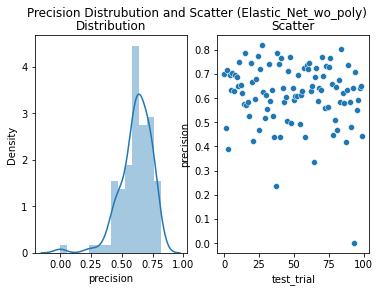

In [62]:
fig, axes = plt.subplots(1, 2)
fig.suptitle("Precision Distrubution and Scatter (Elastic_Net_wo_poly)")
axes[0].set_title("Distribution")
axes[1].set_title("Scatter")
sns.distplot(elastic_wo_poly_result["precision"], ax = axes[0])
sns.scatterplot(x = "test_trial", y = "precision", data=elastic_wo_poly_result, ax = axes[1])

C:\Users\steve\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Scatter'}, xlabel='test_trial', ylabel='precision'>

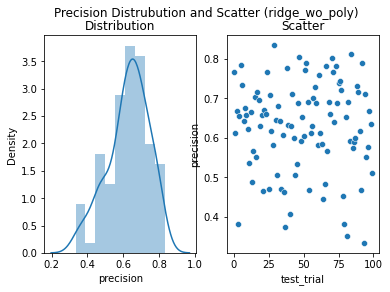

In [63]:
fig, axes = plt.subplots(1, 2)
fig.suptitle("Precision Distrubution and Scatter (ridge_wo_poly)")
axes[0].set_title("Distribution")
axes[1].set_title("Scatter")
sns.distplot(ridge_wo_poly_result["precision"], ax = axes[0])
sns.scatterplot(x = "test_trial", y = "precision", data=ridge_wo_poly_result, ax = axes[1])

C:\Users\steve\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Scatter'}, xlabel='test_trial', ylabel='precision'>

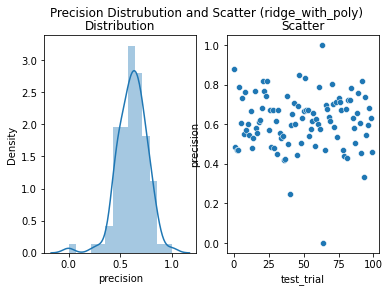

In [64]:
fig, axes = plt.subplots(1, 2)
fig.suptitle("Precision Distrubution and Scatter (ridge_with_poly)")
axes[0].set_title("Distribution")
axes[1].set_title("Scatter")
sns.distplot(ridge_w_poly_result["precision"], ax = axes[0])
sns.scatterplot(x = "test_trial", y = "precision", data=ridge_w_poly_result, ax = axes[1])

C:\Users\steve\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Scatter'}, xlabel='test_trial', ylabel='precision'>

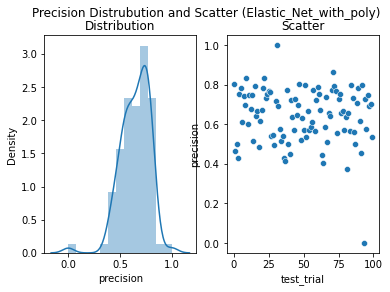

In [65]:
fig, axes = plt.subplots(1, 2)
fig.suptitle("Precision Distrubution and Scatter (Elastic_Net_with_poly)")
axes[0].set_title("Distribution")
axes[1].set_title("Scatter")
sns.distplot(elastic_w_poly_result["precision"], ax = axes[0])
sns.scatterplot(x = "test_trial", y = "precision", data=elastic_w_poly_result, ax = axes[1])